<a href="https://colab.research.google.com/github/Dyotson/FrostGuard/blob/main/ML/graph_model_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/TorchSpatiotemporal/tsl.git
!pip install open-meteo
!pip install openmeteo-requests
!pip install requests-cache
!pip install retry-requests
!pip install pytorch-lightning


2.4.1+cu121
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-2orukrd4
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-2orukrd4
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 56d53d03a7326c7882d33345a759df1b02bcb4f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/TorchSpatiotemporal/tsl.git to /tmp/pip-req-build-r04nem6w
  Running command git clone --filter=blob:none --quiet https://github.com/TorchSpatiotemporal/tsl.git /tmp/pip-req-build-r04nem6w
  Resolved https://github.com/TorchSpatiotemporal/tsl.git to commit f9e5081d198cc4e568a41b0ba472fce0f603c61b
  Preparing metadata (setup.py) ... done


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import tsl
import torch
import numpy as np
import pandas as pd
from tsl.datasets import MetrLA
from tsl.ops.connectivity import edge_index_to_adj
from tsl.data import SpatioTemporalDataset
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler
import torch.nn as nn

from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation

from tsl.metrics.torch import MaskedMSE, MaskedMAPE
from tsl.engines import Predictor

from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from open_meteo import *
from tsl.data import Data


In [ ]:
# Requeried code
#%%
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import itertools
import numpy as np
import torch
from scipy.spatial.distance import cdist

import requests
from requests.auth import HTTPBasicAuth
from datetime import datetime


def get_climate_data(start_date, end_date, lat, lon):
    """
    Function to get climate data from the Meteomatics API
    :param start_date: Start date of the data in format YYYY-MM-DD
    :param end_date: End date of the data in format YYYY-MM-DD
    :param lat: Latitude of the location in decimal degrees with dot
    :param lon: Longitude of the location in decimal degrees with dot
    :return: Dataframe with the climate data
    """
    payload = {"inUserName": "militzer_maximiliano", "inUserPass": "2ji2WoYD2h"}
    location = f"{lat},{lon}"

    # Transform the dates to the correct format

    # Get Temperature above 2 meters, pressure, wind above 10 meters and humidity
    data_params = "t_2m:C,sfc_pressure:psi,wind_speed_10m:kmh,relative_humidity_2m:p"

    # Get the data from the API
    response = requests.get(
        f"https://api.meteomatics.com/{start_date}T00:00:00Z--{end_date}T00:00:00Z:PT1H/{data_params}/{location}/json",
        auth=HTTPBasicAuth(payload["inUserName"], payload["inUserPass"]),
    )
    return response.json()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

def nsew_to_lat_long(coordinates):
    split = coordinates.split(' ')
    ns = (split[0].strip('°'))
    if 'S' in ns:
        ns = '-' + ns
    ew = (split[1].strip('°'))
    if 'W' in ew:
        ew = '-' + ew
    latitude = ns[:-2]
    longitude = ew[:-2]
    return float(latitude), float(longitude) # latitude, longitud


def scrap_json(json_meteomatics):
    data = json_meteomatics['data']

#   out_meteo = pd.DataFrame(columns = ['Date', 't_2m:C','sfc_pressure:psi', 'wind_speed_10m:kmh','relative_humidity_2m:p'])
    merge_original = pd.DataFrame()
    for i in data:
        parameter = i['parameter']
        dates = pd.DataFrame.from_dict(i['coordinates'][0]['dates'])
        dates.rename(columns = {'value':f'{parameter}'}, inplace = True)
        # print(dates)
        if merge_original.empty:
            merge_original = dates
        else:
            merge_original = merge_original.merge(dates ,on = 'date')
    return merge_original

def get_4month_weather(lat, lon, start_date, end_date):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Make sure all required weather variables are listed here
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            'relative_humidity_2m',
            'wind_speed_10m',
            'surface_pressure'
        ],
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location
    response = responses[0]

# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")

    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_rel_hum_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_surf_pressure = hourly.Variables(3).ValuesAsNumpy()
    # print(hourly_temperature_2m)
    h_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }

    h_data['temperature_2m'] = hourly_temperature_2m
    h_data['rel_hum_2m'] = hourly_rel_hum_2m
    h_data['hourly_wind_speed_10m'] = hourly_wind_speed_10m
    h_data['surf_pressure'] = hourly_surf_pressure
    h_dataframe = pd.DataFrame(data=h_data)

    return h_dataframe

def get_weather_batch(
    coords: list,
    start_d: str,
    end_d: str
) -> list:
    list_weather = []
    for coorde in coords:
        lat, lon = nsew_to_lat_long(coorde)

        json_meteo = get_climate_data(start_d, end_d, lat, lon)
        df_w = scrap_json(json_meteo)

        list_weather.append(df_w)
    # print(list_weather)
    return list_weather

def gen_distance_matrix(list_coords: list) -> pd.DataFrame:
    n_nodes = [f'node_{i+1}' for i in range(len(list_coords))]

    distance_matrix = pd.DataFrame(0, columns=n_nodes, index = n_nodes, dtype = float)
    for i, j in itertools.combinations(n_nodes,2):
        index = int(i.split('_')[1])-1
        index2 = int(j.split('_')[1])-1
        coord1 = np.array([nsew_to_lat_long(list_coords[index])])
        coord2 = np.array([nsew_to_lat_long(list_coords[index2])])

        distance_matrix.at[i,j] = 1/cdist(coord1, coord2)
        distance_matrix.at[j,i] = distance_matrix.loc[i, j]
    return distance_matrix

def format_result(list_df,
                  map_channel):
    list_nodes = np.arange(1, len(list_df)+1)
    list_parameters = np.arange(1, len(list_df[0].columns[1:])+1)
    list_two_col = list(itertools.product(list_nodes, list_parameters))
    t = len(list_df[0].index)
    n = len(list_nodes)
    f = len(list_parameters)
    tensor_results = torch.zeros([t,n ,f])
    for i in list_nodes:
        print(i)
        print(list_df[i-1].iloc[:, 1:])
        tensor_results[:, i-1, :] = torch.tensor(list_df[i-1].iloc[:, 1:].values)
    return tensor_results




def distance_to_connectivity(distance_matrix):
    edges = []
    edges_w = []

    for i, j in itertools.combinations(distance_matrix.columns, 2):
        i_index = int(i.split('_')[1])-1
        j_index = int(j.split('_')[1])-1
        edges.append([i_index,j_index])
        edges_w_value = distance_matrix.loc[i,j]
        edges_w.append(edges_w_value)

    return torch.tensor(edges).T, torch.tensor(edges_w)


In [ ]:
pin1 = '34.455737°S 70.925231°W'
pin2 = '34.452217°S 70.920077°W'
pin3 = '34.454563°S 70.911596°W'
pin4 = '34.457393°S 70.908903°W'
pin5 = '34.460729°S 70.914312°W'
pin6 = '34.456189°S 70.916805°W'
coords = [
    pin1,
    pin2,
    pin3,
    pin4,
    pin5,
    pin6
]
# lat, lon = nsew_to_lat_long('34.455737°S 70.925231°W')
# # print(lat, long)
start_date = "2021-05-01"
end_date = "2024-03-01"  # 4 months later


# Get the weather data
w_list = get_weather_batch(coords,
                            start_d=start_date,
                            end_d=end_date)

distance_matrix = gen_distance_matrix(coords)
edges, edges_w = distance_to_connectivity(distance_matrix)

channels_tens = format_result(w_list,
                            map_channel={
                                1: 't_2m:C',
                                2: 'relative_humidity_2m:p',
                                3: 'wind_speed_10m:kmh',
                                4: 'sfc_pressure:psi'
                            })
time = w_list[0].date

       t_2m:C  sfc_pressure:psi  wind_speed_10m:kmh  relative_humidity_2m:p
0        13.3           14.3360                 4.7                    80.3
1        13.7           14.3321                 2.9                    77.0
2        12.9           14.3457                 4.2                    81.1
3        12.5           14.3413                 2.5                    82.7
4        12.0           14.3368                 4.4                    87.5
...       ...               ...                 ...                     ...
24836    32.4           14.2515                10.4                    26.2
24837    31.9           14.2528                 9.4                    26.7
24838    30.6           14.2540                 7.9                    30.2
24839    27.1           14.2583                 7.3                    40.8
24840    24.1           14.2651                 4.9                    45.9

[24841 rows x 4 columns]
       t_2m:C  sfc_pressure:psi  wind_speed_10m:kmh  relative_

(array([  569.,  6685., 26987., 36935., 28498., 19394., 11581.,  8960.,
         7575.,  1862.]),
 array([-0.30000001,  3.3599999 ,  7.01999998, 10.67999935, 14.34000015,
        18.        , 21.65999985, 25.31999969, 28.97999954, 32.63999939,
        36.29999924]),
 <BarContainer object of 10 artists>)

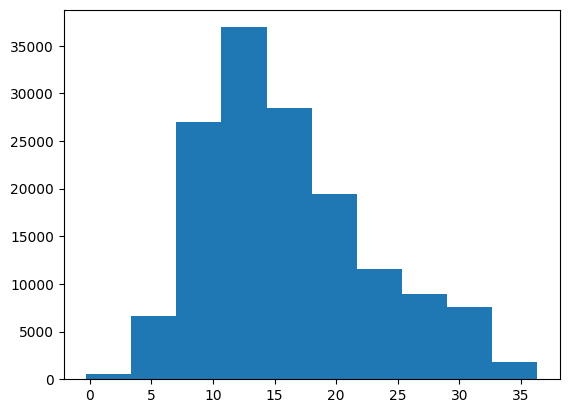

In [ ]:
plt.hist(channels_tens[:,:,0].flatten())

In [ ]:
tens = len(channels_tens[:,1,1])
inp = {
 'x' : channels_tens[:,:,:]
}

target = {
    'y': channels_tens[:, :,1]
}
pattern = {'x':'t n f', 'y' : 't n'}
data_model = Data(
    input = inp,
    target = target,
    has_mask=False,
    pattern = pattern,
    edge_index=edges,
    edge_weight = edges_w,
    dist = distance_matrix
)

In [ ]:
torch_dataset = SpatioTemporalDataset(target=data_model.input.x,
                                      connectivity=(edges, edges_w),
                                      mask = None,
                                      index = time,
                                      horizon=24,
                                      window=48,
                                      stride=1)

In [ ]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler

# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)

In [ ]:
dm.setup()
print(dm)

SpatioTemporalDataModule(train_len=17787, val_len=1933, test_len=4954, scalers=[target], batch_size=64)


In [ ]:
# Install necessary packages

import torch
from tsl.nn.blocks.encoders import RNN, SpatioTemporalTransformerLayer
from tsl.nn.layers.graph_convs import GATConv
# Import torch explicitly

class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_kernel: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.encoder = SpatioTemporalTransformerLayer(input_size, hidden_size, ff_size = 2,
                                                      n_heads = 4, dropout = 0.01)

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.time_nn = RNN(input_size=hidden_size,
                           hidden_size=hidden_size,
                           n_layers=rnn_layers,
                           cell='lstm',
                           return_only_last_state=True,
                           dropout = 0.1)

        self.space_nn = DiffConv(in_channels=hidden_size,
                                 out_channels=hidden_size,
                                 k=gnn_kernel)

        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        # x: [batch time nodes features]
        edge_index = edge_index  # Convert edge_index to np.int64 before creating tensor

        # Check for NaN or Inf in edge_weight and replace them with 0
        edge_weight = torch.nan_to_num(edge_weight, nan=0.0, posinf=0.0, neginf=0.0)

        # print(f"Shape of x before encoder: {x.shape}")

        x_enc = self.encoder(x)  # linear encoder: x_enc = xΘ + b
        x_emb = x_enc + self.node_embeddings()  # add node-identifier embeddings
        h = self.time_nn(x_emb)  # temporal processing: x=[b t n f] -> h=[b n f]

        # Try converting edge_weight to float32
        z = self.space_nn(h, edge_index, edge_weight.float())  # spatial processing
        if isinstance(z, tuple):
            z = z[0]

        x_out = self.decoder(z)  # linear decoder: z=[b n f] -> x_out=[b n t⋅f]
        x_horizon = self.rearrange(x_out)
        return x_horizon

In [ ]:
torch_dataset[0].input

StorageView(x=[48, 6, 4], edge_index=[2, 15], edge_weight=[15])

In [ ]:
hidden_size = 16
rnn_layers = 2
gnn_kernel = 2

input_size = torch_dataset.n_channels  # 3 channel
n_nodes = torch_dataset.n_nodes         # 6 nodes
horizon = torch_dataset.horizon         # 24 time steps
output_size = input_size

stgnn = TimeThenSpaceModel(input_size=input_size,
                           n_nodes=n_nodes,
                          #  output_size = output_size,
                           horizon=horizon,
                           hidden_size=hidden_size,
                           rnn_layers=rnn_layers,
                           gnn_kernel=gnn_kernel)
print(stgnn)
print_model_size(stgnn)

TimeThenSpaceModel(
  (encoder): SpatioTemporalTransformerLayer(
    (temporal_att): MultiHeadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      (q_proj): Linear(4, 16, bias=True)
    )
    (spatial_att): MultiHeadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      (q_proj): Identity()
    )
    (skip_conn): Linear(in_features=4, out_features=16, bias=True)
    (norm1): LayerNorm(4)
    (norm2): LayerNorm(16)
    (mlp): Sequential(
      (0): LayerNorm(16)
      (1): Linear(in_features=16, out_features=2, bias=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.01, inplace=False)
      (4): Linear(in_features=2, out_features=16, bias=True)
      (5): Dropout(p=0.01, inplace=False)
    )
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (node_embeddings): NodeEmbedding(n_nodes=6, embedding_size=16)
  (time_nn): RNN(
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.1

In [ ]:

loss_fn = MaskedMSE()

metrics = {'mse': MaskedMSE(),
           'mse_at_2': MaskedMSE(at=2),  # '2' indicates the third time step,
                                          # which correspond to 15 minutes ahead
           'mse_at_10': MaskedMSE(at=10),
           'mse_at_12': MaskedMSE(at=12),
           'mse_at_20': MaskedMSE(at=20),
           'mse_at_24': MaskedMSE(at=2)}

# setup predictor
predictor = Predictor(
    model=stgnn,                   # our initialized model
    optim_class=torch.optim.Adam,  # specify optimizer to be used...
    optim_kwargs={'lr': 0.001},    # ...and parameters for its initialization
    loss_fn=loss_fn,               # which loss function to be used
    metrics=metrics                # metrics to be logged during train/val/test
)

In [ ]:
dm.trainset[0].target

StorageView(y=[24, 6, 4])

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mse',
    mode='min',
)

trainer = pl.Trainer(max_epochs=100,
                     limit_train_batches=100,  # end an epoch after 100 updates
                     accelerator='cpu',
                     callbacks=[checkpoint_callback])

trainer.fit(predictor, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/logs exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | loss_fn       | MaskedMSE          | 0      | train
1 | train_metrics | MetricCollection   | 0      | train
2 | val_metrics   | MetricCollection   | 0      | train
3 | test_metrics  | MetricCollection   | 0      | train
4 | model         | TimeThenSpaceModel | 9.5 K  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=dm);

/usr/local/lib/python3.10/dist-packages/tsl/engines/predictor.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  storage = torch.load(filename, lambda storage, loc: stora

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    22.911725997924805     │
│         test_mse          │    22.911725997924805     │
│      test_mse_at_10       │    24.061140060424805     │
│      test_mse_at_12       │     25.74513816833496     │
│       test_mse_at_2       │    12.864118576049805     │
│      test_mse_at_20       │    28.667423248291016     │
│      test_mse_at_24       │    12.864118576049805     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
out = predictor.predict_batch(batch = torch_dataset[0:1])


In [ ]:
torch_dataset[0:1].target.y

tensor([[[[14.4000, 14.2871,  1.3000, 72.0000],
          [14.4000, 14.2887,  1.2000, 72.0000],
          [14.4000, 14.2814,  1.3000, 71.8000],
          [14.4000, 14.2753,  1.3000, 71.7000],
          [14.4000, 14.2787,  1.4000, 71.7000],
          [14.4000, 14.2829,  1.3000, 71.9000]],

         [[12.4000, 14.3004,  5.5000, 87.0000],
          [12.3000, 14.3021,  5.5000, 87.1000],
          [12.3000, 14.2949,  5.6000, 87.1000],
          [12.3000, 14.2889,  5.5000, 87.1000],
          [12.4000, 14.2923,  5.5000, 87.0000],
          [12.3000, 14.2963,  5.5000, 87.1000]],

         [[12.5000, 14.3028,  4.7000, 85.6000],
          [12.5000, 14.3044,  4.8000, 85.2000],
          [12.6000, 14.2970,  4.8000, 85.0000],
          [12.6000, 14.2909,  4.7000, 85.0000],
          [12.5000, 14.2943,  4.7000, 85.4000],
          [12.5000, 14.2985,  4.7000, 85.3000]],

         [[12.5000, 14.2944,  2.5000, 84.9000],
          [12.6000, 14.2960,  2.5000, 84.3000],
          [12.7000, 14.2887,  2.50

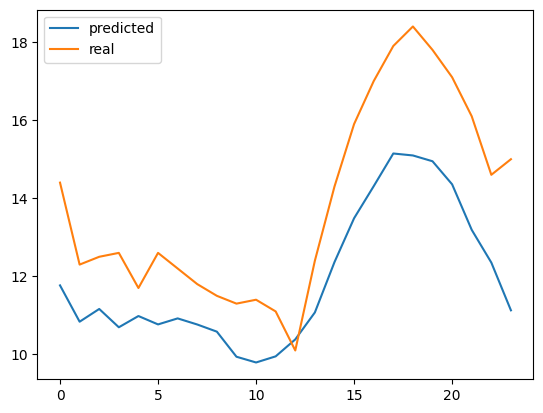

In [ ]:
import matplotlib.pyplot as plt
node_i_f_j = out[:, :, 1, 0]
target1 = torch_dataset[0:1].target.y[:, :, 1, 0]
plt.plot(node_i_f_j.flatten(), label = 'predicted')
plt.plot(target1.flatten(), label = 'real')
plt.legend()

In [ ]:
node_i_f_j.flatten()

tensor([14.3085, 14.3153, 14.3172, 14.3175, 14.3152, 14.3167, 14.3115, 14.3057,
        14.3037, 14.3023, 14.3047, 14.3066, 14.3133, 14.3169, 14.3214, 14.3189,
        14.3185, 14.3152, 14.3099, 14.3067, 14.2990, 14.2997, 14.3021, 14.3061])